In [1]:
%pip install pandas seaborn scikit-learn

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [3]:
digits = load_digits()
X = digits.data
y = digits.target

In [4]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [5]:
def apply_reduction(method, **kwargs):
  model = method(**kwargs)
  X_reduced = model.fit_transform(X_normalized)
  return X_reduced

# Applying each technique
lle = apply_reduction(LocallyLinearEmbedding, n_neighbors=200, n_components=2, random_state=0)
tsne = apply_reduction(TSNE, n_components=2, perplexity=50, random_state=0)
isomap = apply_reduction(Isomap, n_neighbors=200, n_components=2)
laplacian = apply_reduction(SpectralEmbedding, n_neighbors=200, n_components=2)
kernel_pca = apply_reduction(KernelPCA, kernel='rbf', gamma=0.01, n_components=2)
pca = apply_reduction(PCA, n_components=2)

<ipython-input-6-c026abb3d0c5>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


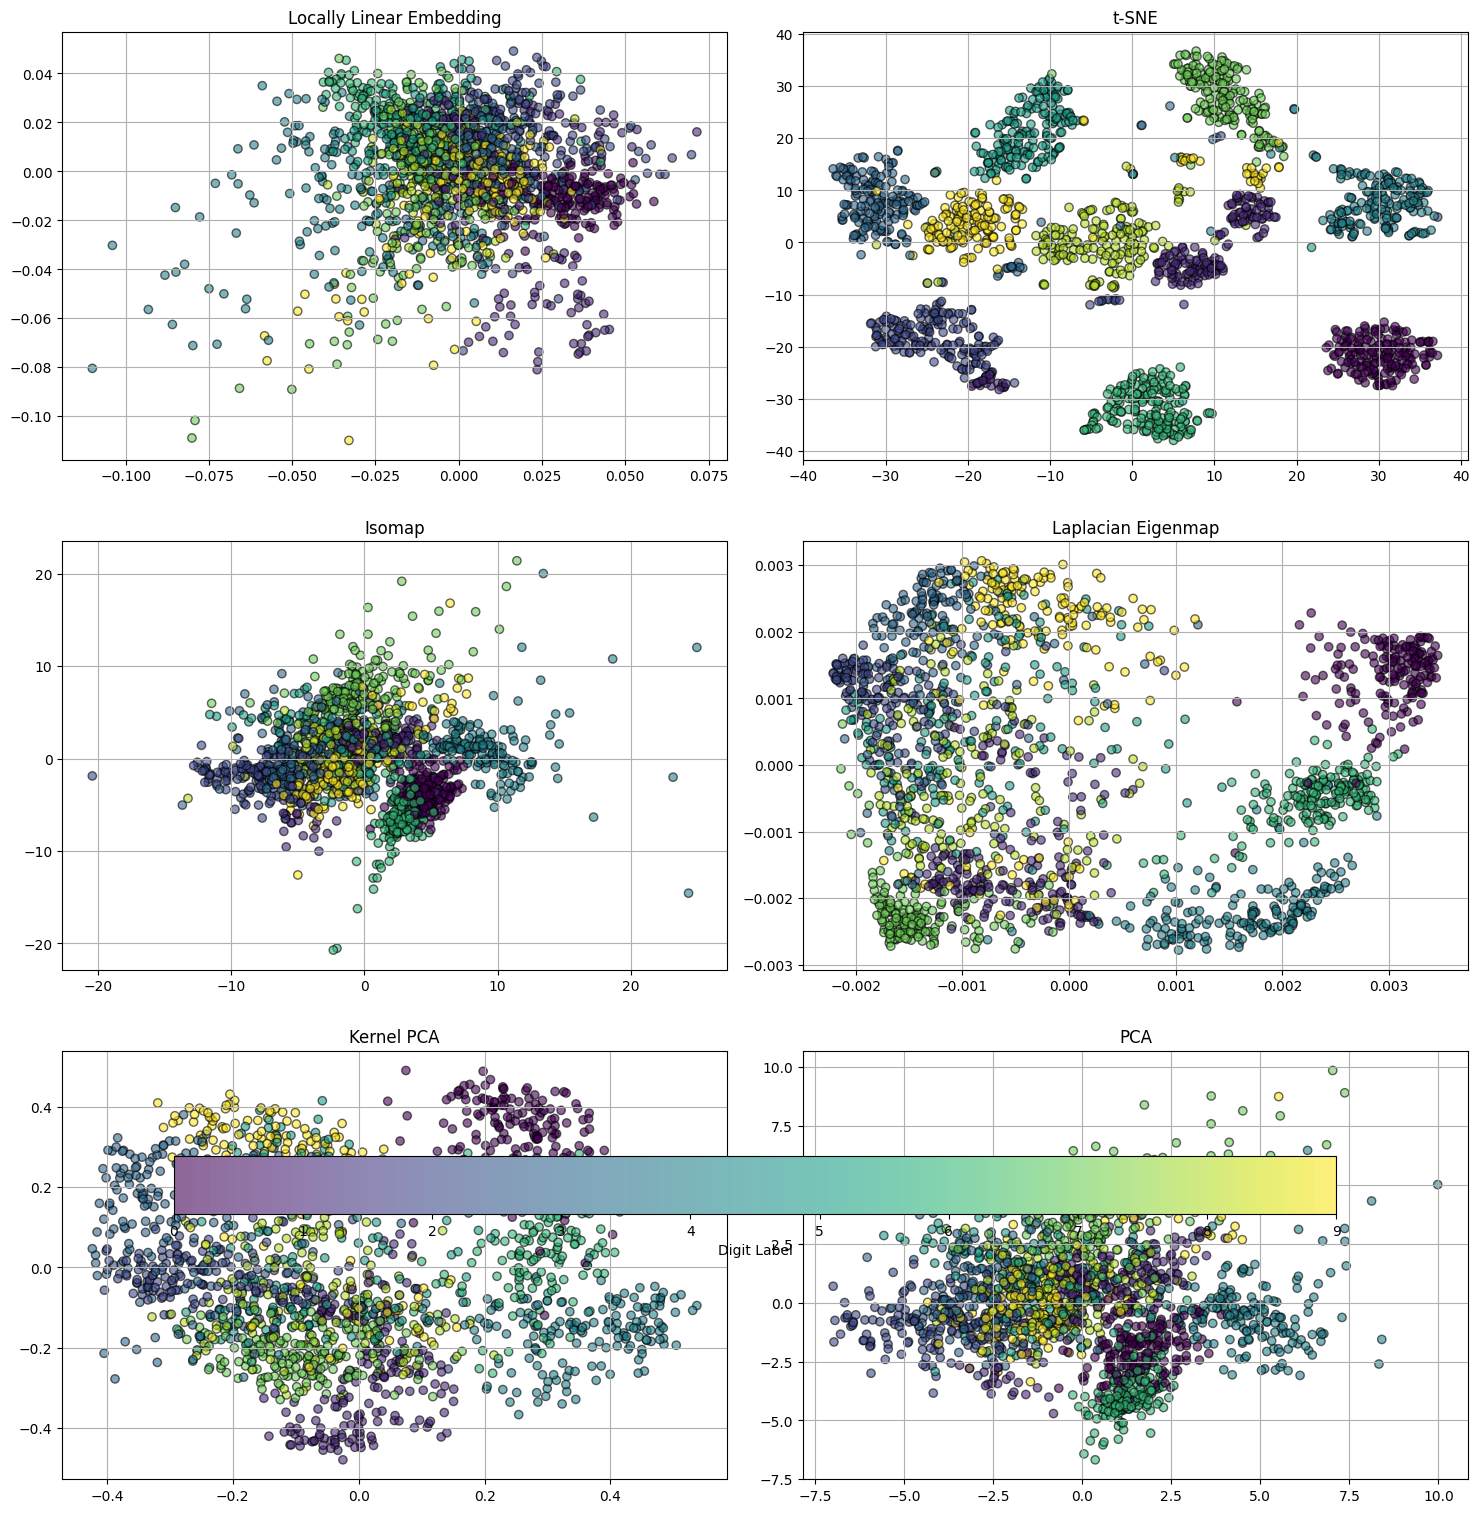

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
techniques = [lle, tsne, isomap, laplacian, kernel_pca, pca]
titles = ['Locally Linear Embedding', 't-SNE', 'Isomap', 'Laplacian Eigenmap', 'Kernel PCA', 'PCA']

for ax, data, title in zip(axs.ravel(), techniques, titles):
  scatter = ax.scatter(data[:, 0], data[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.6)
  ax.set_title(title)
  ax.grid(True)

fig.colorbar(scatter, ax=axs.ravel().tolist(), orientation='horizontal', label='Digit Label')
plt.tight_layout()
plt.show()

Problem b. Classification with(out) Dimensionality Reduction

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

seed = 0
seed_svc = 0

print(f"Seed used for train-test split: {seed}")# np.random.randint((2**31)-1)}")
print(f"Seed used for svc: {seed_svc}")# np.random.randint((2**31)-1)}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

#Method 1: Kernel PCA used
pipe_pca = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('kernel_pca', KernelPCA(kernel='sigmoid',n_components=40)),
        ('classifier', SVC(random_state=seed_svc))
    ]
)

pipe_pca.fit(X_train, y_train.ravel())
print(f"Accuracy of pipeline with PCA: {accuracy_score(pipe_pca.predict(X_test),y_test)}")
print(f"F1 Score of pipeline with PCA: {f1_score(pipe_pca.predict(X_test),y_test,average=None)}")

# Method 2: No dimensionality reduction
pipe_nopca = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('classifier', SVC(random_state=seed_svc))
])
pipe_nopca.fit(X_train,y_train.ravel())
print(f"Accuracy of pipeline with PCA: {accuracy_score(pipe_nopca.predict(X_test), y_test)}")
print(f"F1 Score of pipeline with PCA: {f1_score(pipe_nopca.predict(X_test),y_test,average=None)}")


Seed used for train-test split: 0
Seed used for svc: 0
Accuracy of pipeline with PCA: 0.9981481481481481
F1 Score of pipeline with PCA: [1.         1.         1.         1.         0.99065421 1.
 1.         1.         1.         0.99082569]
Accuracy of pipeline with PCA: 0.9814814814814815
F1 Score of pipeline with PCA: [1.         0.98181818 0.99047619 0.98148148 0.93693694 1.
 0.97196262 0.99082569 0.97142857 0.99065421]


# Comparison of separabiilty of points by different methods

The t-SNE method appeared to be the best at separating the different points into their respective classes.

References:
* https://www.youtube.com/watch?v=P7sxhm6AYjo
* https://www.dropbox.com/scl/fo/3sjixwhdcdgrv5b0iisth/h?dl=0&e=1&preview=Mar+13+-+Linear+Dim+Reduce.mp4&rlkey=d2gsyfotom06erx0jfemcgdw0
* https://www.dropbox.com/scl/fo/3sjixwhdcdgrv5b0iisth/h?dl=0&e=1&preview=Mar+20+-+Nonlinear+Dim+Reduce.mp4&rlkey=d2gsyfotom06erx0jfemcgdw0

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

pipeline_kpca_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA(n_components=40, kernel='sigmoid')),
    ('svc', SVC())
])

pipeline_kpca_svc.fit(X_train, y_train)

y_pred = pipeline_kpca_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy, f1


(0.9981481481481481, 0.9981479893680871)

In [23]:
data = load_digits()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

pipeline_svc.fit(X_train, y_train)

y_pred_svc = pipeline_svc.predict(X_test)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

accuracy_svc, f1_svc

(0.9814814814814815, 0.9816138804681078)